In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import time
import json

In [2]:
# limited data IN
df = pd.read_csv("../outputs/geoc_inv_US_2011_2020.csv", sep=";")

In [3]:
# create locations table
locations = df[["lat", "lng"]].drop_duplicates()
locations["location_id"] = locations.index + 1

In [4]:
# add Point geometry for spatial join
locations["geometry"] = [Point(xy) for xy in zip(locations.lng, locations.lat)]
locations = gpd.GeoDataFrame(locations, geometry="geometry", crs="EPSG:4326")

In [5]:
# census tract geoms
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/shape_files/censustract_geoms_top50.geojson').readlines()]
)
tract_geoms = tract_geoms.set_crs("epsg:4326")

In [6]:
def locations_to_census_tracts(points, tracts):
    """spatial join locations to census tracts"""
    location_with_tract = gpd.sjoin(
        points,
        tracts,
        "left",
        "within",
    )
    return location_with_tract

In [7]:
# add census tract IDs to locations
locations = locations_to_census_tracts(locations, tract_geoms)
locations.dropna(subset=["full_geoid"], inplace=True)

In [8]:
# add cbsacode
cbsa = pd.read_csv("../data/cbsacode_shortname_tracts.csv", sep=";", index_col=0)

locations = pd.merge(
    locations,
    cbsa,
    left_on="full_geoid",
    right_on="geoid",
    how="left"
)

In [9]:
# nodelist with key columns ONLY
nodelist = locations[["location_id", "lng", "lat", "geoid", "cbsacode", "short_name"]].rename(columns={"lng":"lon"})

In [11]:
# export
nodelist.to_csv("../outputs/inventor_nodelist_2011_2020.csv", sep=";", index=False)

In [10]:
nodelist.head(2)

,location_id,lon,lat,geoid,cbsacode,short_name
0,2,-96.9584,32.8629,14000US48113014312,19100.0,Dallas
1,3,-88.0135,42.0521,14000US17031770202,16980.0,Chicago


In [36]:
# join location IDs to df
df2 = pd.merge(
    df,
    locations,
    on=["lat", "lng"],
    how="left"
)

In [37]:
def edgelist_construction(df, key_cols, directed):
    """create location-location edgelist"""
    
    # focus the dataframe
    df = df[key_cols].drop_duplicates()


    # create edgelist by join
    el = pd.merge(
        df,
        df,
        on=key_cols[0],
        suffixes=["1", "2"]
    )

    # directed
    if directed == True:
        el = el[el.iloc[:, 1] != el.iloc[:, 2]]
    else:
        el = el[el.iloc[:, 1] < el.iloc[:, 2]]
    
    # final dataframe
    el = el.iloc[:, 1:]

    return el

In [38]:
# create the edgelist
start_time = time.time()
el = edgelist_construction(df2, key_cols=["appln_id", "location_id"], directed=False)
print("--- %s seconds ---" % round((time.time() - start_time), 3))

--- 0.444 seconds ---


In [39]:
# add the coordinates to the edgelist
el = pd.merge(
    el,
    nodelist,
    left_on="location_id1",
    right_on="location_id",
    how="left"
)
el = pd.merge(
    el,
    nodelist,
    left_on="location_id2",
    right_on="location_id",
    how="left",
    suffixes=["1","2"]
)

# remove duplicate columns
el = el.loc[:,~el.columns.duplicated()].copy()

/var/folders/9d/8j37_fks51x11mk0_zwqsd940000gn/T/ipykernel_13523/131426411.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'location_id1'} in the result is deprecated and will raise a MergeError in a future version.
  el = pd.merge(


In [68]:
# focus on ties INSIDE metropolitan areas
print(el.shape)
el = el[el["short_name1"] == el["short_name2"]]
print(el.shape)

(707750, 12)
(395580, 12)


In [40]:
el.head(2)

,location_id1,location_id2,lon1,lat1,geoid1,cbsacode1,short_name1,lon2,lat2,geoid2,cbsacode2,short_name2
0,6.0,7.0,-122.0550,37.3207,14000US06085507701,41940.0,San Jose,-122.126,37.4042,14000US06085510600,41940.0,San Jose
1,8.0,9.0,-96.9449,32.8138,14000US48113014902,19100.0,Dallas,-96.935,32.8611,14000US48113014206,19100.0,Dallas


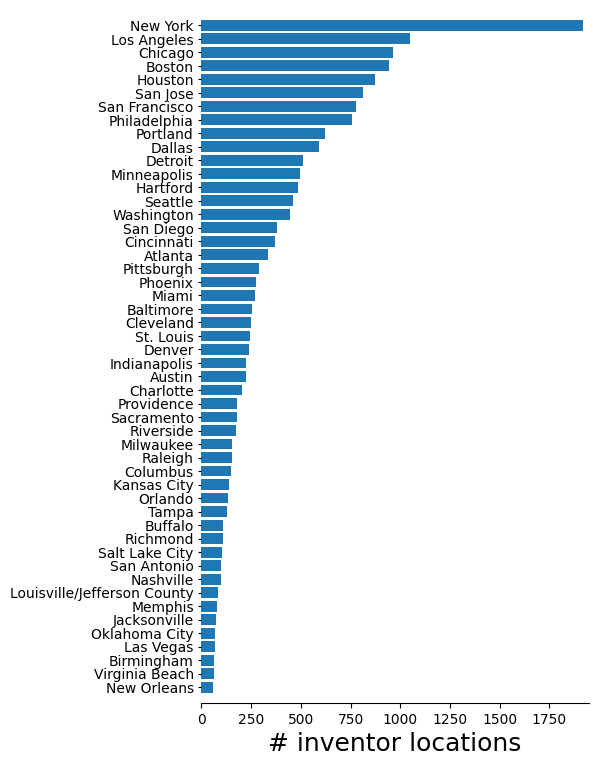

In [49]:
# plot the number of inventors -- connected locations..
def inventor_per_metro_plot(nodelist, ax=None):
    pdata = nodelist.groupby(["short_name"])["location_id"].agg("nunique").reset_index().sort_values(by="location_id")

    if ax is None:
        ax = plt.gca()
    ax.barh(pdata["short_name"], pdata["location_id"])  
    ax.margins(0.015, tight=True)
    ax.set_xlabel("# inventor locations", size=18)
    ax.tick_params("y", size=2, labelsize=10)
    ax.tick_params("x", labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(5, 9))
inventor_per_metro_plot(nodelist, ax=ax)

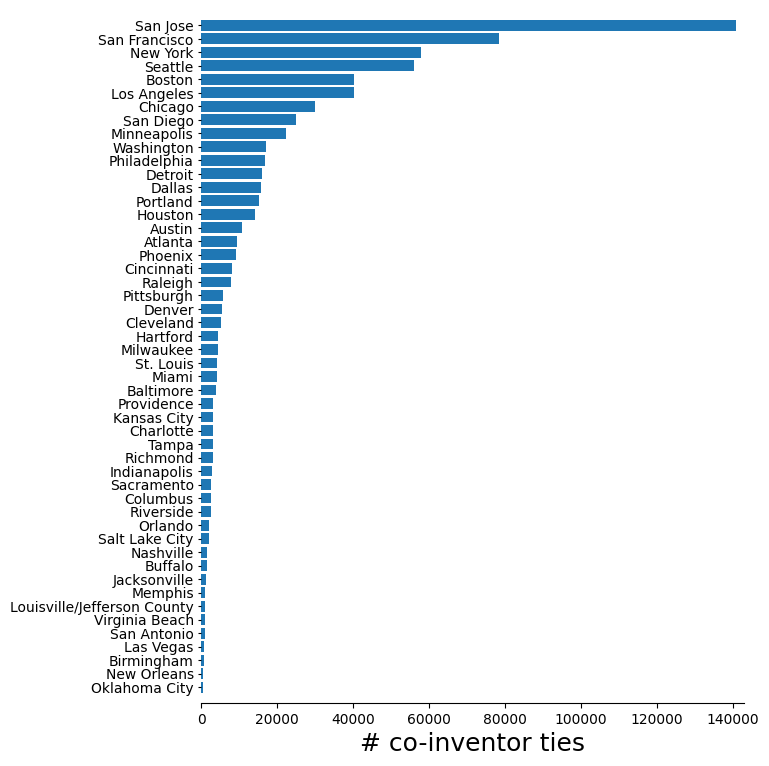

In [50]:
# plot the number of edges inside metros
def edges_inside_metros(el, ax=None):
    pdata = el.groupby(["short_name1"])["location_id1"].agg("count").reset_index().sort_values(by="location_id1")

    if ax is None:
        ax = plt.gca()
    ax.barh(pdata["short_name1"], pdata["location_id1"])  
    ax.margins(0.015, tight=True)
    ax.set_xlabel("# co-inventor ties", size=18)
    ax.tick_params("y", size=2, labelsize=10)
    ax.tick_params("x", labelsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

fig, ax = plt.subplots(1,1, figsize=(7, 9))
edges_inside_metros(el, ax=ax)